### Denoising fMRI Scans with Diffusion Models:

## Training with Mask as Condition

This Code is based on the implementation of the Super-Resolution Network SR3: https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement.git

Changes were made throughout the full code to convert the super-resolution architecture to a denoising-architecture with an additional masked loss from Structural MRI (anatomy).
______

Imports

In [ ]:
import torch
import argparse
import logging
import os
import numpy as np

from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset
import random
from re import split
import torch.utils.data

# import torch.nn as nn
from collections import OrderedDict

import functools
from torch.nn import init
from torch.nn import modules

# u-net
import math
import torch.nn.functional as F
from inspect import isfunction

# diffusion
from torch import nn
from functools import partial
from tqdm import tqdm

# learning rate scheduler
import torch.optim.lr_scheduler as lr_scheduler

# mixed precision training for memory
from torch.cuda.amp import GradScaler
from torch.amp import autocast

# activation checkpointing
import torch.utils.checkpoint as checkpoint

# read masks
import nibabel as nib
import matplotlib.pyplot as plt

Config

In [ ]:
opt = {
    "name": "denoising",
    "phase": "train",
    "gpu_ids": [0, 1], 
    "debug": False,  
    "enable_wandb": False,  
    "log_wandb_ckpt": False,  
    "log_eval": False,  
    "path": {
        "log": "/kaggle/working/logs",
        "tb_logger": "/kaggle/working/tb_logger",
        "results": "/kaggle/working/results",
        "checkpoint": "/kaggle/working/checkpoint",
        "resume_state": None
    },
    "datasets": {
        "train": {
            "noisy_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/noisy_func_train_3.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/gt_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/gt_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/gt_func_train_3.npy'],
            "mask_data_paths": ['/kaggle/input/brain-masks/brain_mask_01.nii',
                 '/kaggle/input/brain-masks/brain_mask_dd.nii',
                 '/kaggle/input/brain-masks/brain_mask_gg.nii'],
            "batch_size": 2,
            "num_workers": 4,
            "use_shuffle": True
        },
        "test": {
            "noisy_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/noisy_func_test.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-test/data/gt_func_test.npy'],
            "mask_data_paths": ['/kaggle/input/brain-masks/brain_mask_uu.nii'],
        }
    },
    "model": {
        "which_model_G": "sr3",
        "finetune_norm": False,
        "unet": {
            "in_channel": 3,
            "out_channel": 1,
            "inner_channel": 64,
            "norm_groups": 16,
            "channel_multiplier": [1, 2, 4, 8],
            "attn_res": [8],
            "res_blocks": 1,
            "dropout": 0.1
        },
        "beta_schedule": {
            "train": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            },
            "test": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
        },
        "diffusion": {
            "image_size": 64,
            "channels": 1,
            "conditional": True
        }
    },
    "train": {
        "n_iter": 18000,
        "val_freq": 1e4,
        "save_checkpoint_freq": 1800,
        "print_freq": 100,
        "optimizer": {
            "type": "adam",
            "lr": 5e-5
        },
        "ema_scheduler": {
            "step_start_ema": 1000,
            "update_ema_every": 10,
            "ema_decay": 0.999
        }
    },
    "wandb": {
        "project": "distributed_high_sr_ffhq"
    },
    "config_file": "config/sr_sr3_16_128.json"  # from CLI
}

In [ ]:
os.makedirs(opt['path']['log'], exist_ok=True)
os.makedirs(opt['path']['tb_logger'], exist_ok=True)
os.makedirs(opt['path']['results'], exist_ok=True)
os.makedirs(opt['path']['checkpoint'], exist_ok=True)

Logger

In [ ]:
# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def dict2str(opt, indent_l=1):
    '''dict to string for logger'''
    msg = ''
    for k, v in opt.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg

def setup_logger(logger_name, root, phase, level=logging.INFO, screen=False):
    '''set up logger'''
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(
        '%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s', datefmt='%y-%m-%d %H:%M:%S')
    log_file = os.path.join(root, '{}.log'.format(phase))
    fh = logging.FileHandler(log_file, mode='w')
    fh.setFormatter(formatter)
    l.setLevel(level)
    l.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        l.addHandler(sh)

setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')

Dataset creation

In [ ]:
class PairwiseDataset(Dataset):
    def __init__(self, noisy_images_paths: list, gt_images_paths: list, mask_images_paths: list):
        """Initialize fMRI dataset for denoising with memory-efficient loading.
        
        Args:
            noisy_images_paths (list): List of paths to noisy fMRI volumes (.npy files)
            gt_images_paths (list): List of paths to ground truth fMRI volumes (.npy files)
            mask_images_paths (list): List of paths to brain mask volumes (.nii files)
        """
        self.noisy_paths = noisy_images_paths
        self.gt_paths = gt_images_paths
        self.mask_paths = mask_images_paths
        


        self.mask_volumes = [np.rot90(nib.load(path).get_fdata(), k=1, axes=(0, 1)) for path in mask_images_paths]
        
        self.file_slice_mapping = []
        self.z_t_dimension_sizes = []
        total_slices = 0
        dataset_length = 0 

        for i, path in enumerate(noisy_images_paths):
            
            data_shape = np.load(path, mmap_mode='r').shape
            num_slices = data_shape[2] * data_shape[3]  # z * t
            self.z_t_dimension_sizes.append((data_shape[2], data_shape[3]))
            
            for batch_idx in range(0, data_shape[3]):
                self.file_slice_mapping.append((i, batch_idx))
                dataset_length += 1
            
            total_slices += num_slices 
            
        self.data_len = dataset_length

    def __len__(self):
        return self.data_len


    def __getitem__(self, index):
        file_idx, t_idx = self.file_slice_mapping[index]
        
        noisy_file_path = self.noisy_paths[file_idx]
        gt_file_path = self.gt_paths[file_idx]
        
        mask_volume = self.mask_volumes[file_idx]
        noisy_volume = np.load(noisy_file_path, mmap_mode='r')
        gt_volume = np.load(gt_file_path, mmap_mode='r')
        
        noisy_slice = noisy_volume[:, :, :, t_idx].copy() 
        gt_slice = gt_volume[:, :, :, t_idx].copy()
        
        return {
            'GT': torch.tensor(gt_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Noisy': torch.tensor(noisy_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Mask': torch.tensor(mask_volume.copy()).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Index': index
        }

In [ ]:
def collate_merge_batches(batch):
    merged = {
        'Noisy': torch.cat([item['Noisy'] for item in batch], dim=0),
        'GT': torch.cat([item['GT'] for item in batch], dim=0),
        'Mask': torch.cat([item['Mask'] for item in batch], dim=0),
        'Index': [item['Index'] for item in batch]
    }
    return merged

def create_dataloader(dataset, dataset_opt, phase):
    '''create dataloader '''
    if phase == 'train':
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=dataset_opt['batch_size'],
            shuffle=dataset_opt['use_shuffle'],
            num_workers=dataset_opt['num_workers'],
            pin_memory=True,
            collate_fn = collate_merge_batches)
    elif phase == 'test':
        return torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, collate_fn = lambda x: x[0])
    else:
        raise NotImplementedError(
            'Dataloader [{:s}] is not found.'.format(phase))

In [8]:
# Create training dataset and dataloader
train_set = PairwiseDataset(
    opt['datasets']['train']['noisy_data_paths'], 
    opt['datasets']['train']['gt_data_paths'],
    opt['datasets']['train']['mask_data_paths']
)
train_loader = create_dataloader(
    train_set, 
    opt['datasets']['train'], 
    'train'
)
logger.info('Training dataset with {} instances created.'.format(len(train_set)))

# Create testing dataset and dataloader
test_set = PairwiseDataset(
    opt['datasets']['test']['noisy_data_paths'], 
    opt['datasets']['test']['gt_data_paths'],
    opt['datasets']['test']['mask_data_paths']
)
test_loader = create_dataloader(
    test_set, 
    opt['datasets']['test'], 
    'test'
)
logger.info('Test dataset with {} instances created.'.format(len(test_set)))

25-06-23 20:37:09.725 - INFO: Training dataset with 900 instances created.
25-06-23 20:37:09.757 - INFO: Test dataset with 300 instances created.


In [ ]:
gt_slice = train_set[400]["GT"]
mask_slice = train_set[400]["Mask"]

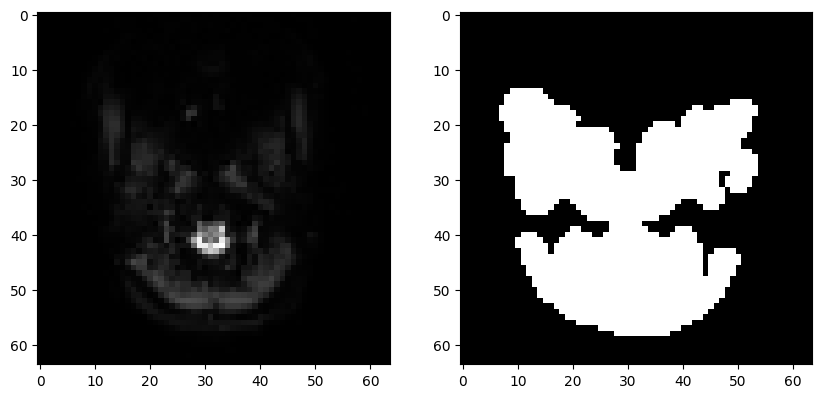

In [ ]:
# example visualization of mask and gt
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth image
axes[0].imshow(gt_slice[0,0,:,:], cmap='gray')
axes[1].imshow(mask_slice[0,0,:,:], cmap='gray')

## Model loading

Generic Functions

In [ ]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

U-Net

In [ ]:
# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                
                x = checkpoint.checkpoint(layer, x, t, use_reentrant=False) # wrap

            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = checkpoint.checkpoint(layer, x, t, use_reentrant=False) # wrap

            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = checkpoint.checkpoint(layer, torch.cat((x, feats.pop()), dim=1), t, use_reentrant=False)
            else:
                x = layer(x)

        return self.final_conv(x)

Diffusion

In [ ]:
### Diffusion ###
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


# gaussian diffusion trainer class
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True,
        schedule_opt=None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        if schedule_opt is not None:
            pass


    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, schedule_opt, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None, mask=None):
        batch_size = x.shape[0]
        noise_level = torch.tensor(
            [self.sqrt_alphas_cumprod_prev[t+1]], dtype=torch.float32).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            if condition_x.shape[0] != mask.shape[0]:
                repeats = condition_x.shape[0] // mask.shape[0]
                mask = mask.repeat(repeats, 1, 1, 1)

            denoise_input = torch.cat([condition_x, mask, x], dim=1)
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(denoise_input, noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None, mask=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x, mask=mask)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, mask, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x, mask=mask)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, mask, continous=False):
        return self.p_sample_loop(x_in, mask, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['GT']
        noisy_input = x_in['Noisy']
        mask_input = x_in['Mask']
        

        if noisy_input.shape[0] != mask_input.shape[0]:
            repeats = noisy_input.shape[0] // mask_input.shape[0]
            mask_input = mask_input.repeat(repeats, 1, 1, 1)

        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.tensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            ),
            dtype=torch.float32
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([noisy_input, mask_input, x_noisy], dim=1), continuous_sqrt_alpha_cumprod)

        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

Helper functions

In [ ]:
def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, std) 
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    # scale for 'kaiming', std for 'normal'.
    logger.info('Initialization method [{:s}]'.format(init_type))
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(
            weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError(
            'initialization method [{:s}] not implemented'.format(init_type))

Define Network

In [ ]:
# Generator
def define_G(opt):
    model_opt = opt['model']
    if ('norm_groups' not in model_opt['unet']) or model_opt['unet']['norm_groups'] is None:
        model_opt['unet']['norm_groups']=32
    model = UNet(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=model_opt['diffusion']['image_size']
    )
    netG = GaussianDiffusion(
        model,
        image_size=model_opt['diffusion']['image_size'],
        channels=model_opt['diffusion']['channels'],
        loss_type='l2',    # L1 or L2
        conditional=model_opt['diffusion']['conditional'],
        schedule_opt=model_opt['beta_schedule']['train']
    )
    if opt['phase'] == 'train':
        # init_weights(netG, init_type='kaiming', scale=0.1)
        init_weights(netG, init_type='orthogonal')
    if opt['gpu_ids']:
        assert torch.cuda.is_available()
    return netG

Model classes

In [ ]:
class SR3():

    def __init__(self, opt):       
        self.opt = opt
        self.device = torch.device(
            'cuda' if opt['gpu_ids'] is not None else 'cpu')

        # mixed precision training
        self.scaler = GradScaler()
        
        self.begin_step = 0
        self.begin_epoch = 0
        # define network and load pretrained models
        self.netG = self.set_device(define_G(opt))
        self.schedule_phase = None
        

        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()
            # find the parameters to optimize
            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())

            self.optG = torch.optim.Adam(
                optim_params, lr=opt['train']["optimizer"]["lr"],
                weight_decay=1e-6)

            #learning rate scheduler
            self.schedulerG = lr_scheduler.CosineAnnealingLR(
                self.optG, T_max=self.opt['train']['n_iter'], eta_min=1e-6)
            
            self.log_dict = OrderedDict()
        self.load_network()
        self.print_network()

    def set_device(self, x):
        if isinstance(x, dict):
            for key, item in x.items():
                if item is not None and type(item)==torch.Tensor:
                    x[key] = item.to(self.device)
        elif isinstance(x, list):
            for item in x:
                if item is not None:
                    item = item.to(self.device)
        else:
            x = x.to(self.device)
        return x

    def get_network_description(self, network):
        '''Get the string and total parameters of the network'''
        if isinstance(network, nn.DataParallel):
            network = network.module
        s = str(network)
        n = sum(map(lambda x: x.numel(), network.parameters()))
        return s, n

    def feed_data(self, data):
        self.data = self.set_device(data)

    def optimize_parameters(self):
        self.optG.zero_grad()

        # mixed precision
        with torch.cuda.amp.autocast(): 
            l_pix = self.netG(self.data)
            b, c, h, w = self.data['GT'].shape
            l_pix = l_pix.sum()/int(b*c*h*w)

        self.scaler.scale(l_pix).backward()

        # Unscale gradients before clipping (if using GradScaler)
        self.scaler.unscale_(self.optG)
        torch.nn.utils.clip_grad_norm_(self.netG.parameters(), max_norm=1.0) 

        self.scaler.step(self.optG)
        self.scaler.update()  

        #scheduler step
        self.schedulerG.step()

        # set log
        self.log_dict['l_pix'] = l_pix.item()

        return l_pix.item()

    def evaluate_loss(self, data):
        """
        Calculates the diffusion loss for a given batch of data without training.
        Sets model to eval mode and uses torch.no_grad() for efficiency.
        """
        self.netG.eval()
        with torch.no_grad():
            self.feed_data(data)
     
            with torch.cuda.amp.autocast():
                l_pix = self.netG(self.data)
                b, c, h, w = self.data['GT'].shape
                l_pix = l_pix.sum() / int(b * c * h * w)
        self.netG.train() 
        return l_pix.item()
    
    def test(self, continous=False):
        self.netG.eval()
        with torch.no_grad():
            noisy_input = self.data['Noisy']
            mask_input = self.data['Mask']
            
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.super_resolution(
                    noisy_input, mask_input, continous)
            else:
                self.SR = self.netG.super_resolution(
                    noisy_input, mask_input, continous)
        self.netG.train()

    def sample(self, batch_size=1, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.sample(batch_size, continous)
            else:
                self.SR = self.netG.sample(batch_size, continous)
        self.netG.train()

    def set_loss(self):
        if isinstance(self.netG, nn.DataParallel):
            self.netG.module.set_loss(self.device)
        else:
            self.netG.set_loss(self.device)

    def set_new_noise_schedule(self, schedule_opt, schedule_phase='train'):
        if self.schedule_phase is None or self.schedule_phase != schedule_phase:
            self.schedule_phase = schedule_phase
            if isinstance(self.netG, nn.DataParallel):
                self.netG.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG.set_new_noise_schedule(schedule_opt, self.device)

    def get_current_log(self):
        return self.log_dict

    def get_current_visuals(self, need_LR=True, sample=False):
        out_dict = OrderedDict()
        if sample:
            out_dict['SAM'] = self.SR.detach().float().cpu()
        else:
            out_dict['SR'] = self.SR.detach().float().cpu()
            out_dict['Noisy'] = self.data['Noisy'].detach().float().cpu()
            out_dict['GT'] = self.data['GT'].detach().float().cpu()
        return out_dict

    def print_network(self):
        s, n = self.get_network_description(self.netG)
        if isinstance(self.netG, nn.DataParallel):
            net_struc_str = '{} - {}'.format(self.netG.__class__.__name__,
                                             self.netG.module.__class__.__name__)
        else:
            net_struc_str = '{}'.format(self.netG.__class__.__name__)

        logger.info(
            'Network G structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        logger.info(s)

    def save_network(self, epoch, iter_step, is_final=False):
        if is_final:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_opt.pth'.format(iter_step, epoch))
        else:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_opt.pth'.format(iter_step, epoch))
        # gen
        network = self.netG
        if isinstance(self.netG, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, gen_path)
        # opt
        opt_state = {'epoch': epoch, 'iter': iter_step,
                     'scheduler': None, 'optimizer': None}
        opt_state['optimizer'] = self.optG.state_dict()
        torch.save(opt_state, opt_path)

        logger.info(
            'Saved model in [{:s}] ...'.format(gen_path))

    def load_network(self):
        load_path = self.opt['path']['resume_state']
        if load_path is not None:
            logger.info(
                'Loading pretrained model for G [{:s}] ...'.format(load_path))
            gen_path = '{}_gen.pth'.format(load_path)
            opt_path = '{}_opt.pth'.format(load_path)
            # gen
            network = self.netG
            if isinstance(self.netG, nn.DataParallel):
                network = network.module
            network.load_state_dict(torch.load(
                gen_path), strict=(not self.opt['model']['finetune_norm']))

            if self.opt['phase'] == 'train':
                # optimizer
                opt = torch.load(opt_path)
                self.optG.load_state_dict(opt['optimizer'])
                self.begin_step = opt['iter']
                self.begin_epoch = opt['epoch']

Training process

In [ ]:
# model
diffusion = SR3(opt)

/tmp/ipykernel_19/1314524419.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
25-06-23 20:37:43.944 - INFO: Initialization method [orthogonal]
25-06-23 20:37:49.742 - INFO: Network G structure: GaussianDiffusion, with parameters: 42,051,969
25-06-23 20:37:49.743 - INFO: GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): Swish()
      (3): Linear(in_features=256, out_features=64, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (blo

In [ ]:
# Train
epoch_loss_list = []

current_step = diffusion.begin_step
current_epoch = diffusion.begin_epoch
n_iter = opt['train']['n_iter']

if opt['path']['resume_state']:
    logger.info('Resuming training from epoch: {}, iter: {}.'.format(
        current_epoch, current_step))

diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])


if opt['phase'] == 'train':
    while current_step < n_iter:
        current_epoch += 1
        epoch_loss_values = []

        diffusion.optG.zero_grad() 
        
        for _, train_data in enumerate(train_loader): 
            current_step += 1
            if current_step > n_iter:
                break
            diffusion.feed_data(train_data)

            current_l_pix = diffusion.optimize_parameters()
            epoch_loss_values.append(current_l_pix)
                
            # log
            if current_step % opt['train']['print_freq'] == 0:
                logs = diffusion.get_current_log()
                message = '<epoch:{:3d}, iter:{:8,d}> '.format(
                    current_epoch, current_step)
                for k, v in logs.items():
                    message += '{:s}: {:.4e} '.format(k, v)
                logger.info(message)
                
            if current_step % opt['train']['save_checkpoint_freq'] == 0:
                logger.info('Saving models and training states.')
                diffusion.save_network(current_epoch, current_step)
            
            if current_step == n_iter:
                logger.info("Saving final model")
                diffusion.save_network(current_epoch, current_step, is_final=True)


        epoch_loss = sum(epoch_loss_values)/len(epoch_loss_values)
        print('Epoch Loss: ', epoch_loss)
        epoch_loss_list.append(epoch_loss)

    # save model
    print('Epoch Loss List: ', epoch_loss_list)
    logger.info('End of training.')

/tmp/ipykernel_19/1314524419.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # <--- Add this context manager
25-06-23 20:42:32.329 - INFO: <epoch:  1, iter:     100> l_pix: 6.8591e-02 
25-06-23 20:45:33.650 - INFO: <epoch:  1, iter:     200> l_pix: 4.0743e-02 
25-06-23 20:48:34.797 - INFO: <epoch:  1, iter:     300> l_pix: 4.0823e-02 
25-06-23 20:51:35.950 - INFO: <epoch:  1, iter:     400> l_pix: 2.7566e-02 


Epoch Loss:  0.20184037442836497


25-06-23 20:54:38.249 - INFO: <epoch:  2, iter:     500> l_pix: 1.6971e-01 
25-06-23 20:57:39.558 - INFO: <epoch:  2, iter:     600> l_pix: 2.6395e-02 
25-06-23 21:00:40.696 - INFO: <epoch:  2, iter:     700> l_pix: 3.6169e-02 
25-06-23 21:03:41.849 - INFO: <epoch:  2, iter:     800> l_pix: 1.8330e-02 
25-06-23 21:06:43.017 - INFO: <epoch:  2, iter:     900> l_pix: 1.3735e-02 


Epoch Loss:  0.08586113380061255


25-06-23 21:09:45.560 - INFO: <epoch:  3, iter:   1,000> l_pix: 2.7249e-02 
25-06-23 21:12:46.716 - INFO: <epoch:  3, iter:   1,100> l_pix: 1.4435e-02 
25-06-23 21:15:47.874 - INFO: <epoch:  3, iter:   1,200> l_pix: 1.1901e-02 
25-06-23 21:18:49.027 - INFO: <epoch:  3, iter:   1,300> l_pix: 3.0016e-02 


Epoch Loss:  0.07985949934356742


25-06-23 21:21:51.566 - INFO: <epoch:  4, iter:   1,400> l_pix: 3.2783e-01 
25-06-23 21:24:52.723 - INFO: <epoch:  4, iter:   1,500> l_pix: 1.2054e-02 
25-06-23 21:27:53.886 - INFO: <epoch:  4, iter:   1,600> l_pix: 7.4098e-02 
25-06-23 21:30:55.039 - INFO: <epoch:  4, iter:   1,700> l_pix: 9.1579e-03 
25-06-23 21:33:56.205 - INFO: <epoch:  4, iter:   1,800> l_pix: 1.2586e-02 
25-06-23 21:33:56.206 - INFO: Saving models and training states.
25-06-23 21:33:57.056 - INFO: Saved model in [/kaggle/working/checkpoint/I1800_E4_gen.pth] ...


Epoch Loss:  0.08906318487806453


25-06-23 21:36:59.623 - INFO: <epoch:  5, iter:   1,900> l_pix: 9.1028e-03 
25-06-23 21:40:00.770 - INFO: <epoch:  5, iter:   2,000> l_pix: 2.0125e-02 
25-06-23 21:43:01.917 - INFO: <epoch:  5, iter:   2,100> l_pix: 2.7869e-02 
25-06-23 21:46:03.067 - INFO: <epoch:  5, iter:   2,200> l_pix: 1.6958e-01 


Epoch Loss:  0.06878256116786764


25-06-23 21:49:05.704 - INFO: <epoch:  6, iter:   2,300> l_pix: 1.3637e-02 
25-06-23 21:52:06.870 - INFO: <epoch:  6, iter:   2,400> l_pix: 8.9097e-03 
25-06-23 21:55:08.038 - INFO: <epoch:  6, iter:   2,500> l_pix: 9.4833e-02 
25-06-23 21:58:09.207 - INFO: <epoch:  6, iter:   2,600> l_pix: 1.8271e-01 
25-06-23 22:01:10.365 - INFO: <epoch:  6, iter:   2,700> l_pix: 6.8747e-03 


Epoch Loss:  0.05979896244282524


25-06-23 22:04:12.986 - INFO: <epoch:  7, iter:   2,800> l_pix: 5.5219e-03 
25-06-23 22:07:14.156 - INFO: <epoch:  7, iter:   2,900> l_pix: 1.4172e-01 
25-06-23 22:10:15.303 - INFO: <epoch:  7, iter:   3,000> l_pix: 1.8219e-01 
25-06-23 22:13:16.444 - INFO: <epoch:  7, iter:   3,100> l_pix: 5.5446e-03 


Epoch Loss:  0.06266896576310198


25-06-23 22:16:19.136 - INFO: <epoch:  8, iter:   3,200> l_pix: 2.0611e-02 
25-06-23 22:19:20.286 - INFO: <epoch:  8, iter:   3,300> l_pix: 5.9816e-03 
25-06-23 22:22:21.444 - INFO: <epoch:  8, iter:   3,400> l_pix: 7.5819e-02 
25-06-23 22:25:22.587 - INFO: <epoch:  8, iter:   3,500> l_pix: 9.0140e-03 
25-06-23 22:28:23.733 - INFO: <epoch:  8, iter:   3,600> l_pix: 5.3379e-01 
25-06-23 22:28:23.734 - INFO: Saving models and training states.
25-06-23 22:28:24.560 - INFO: Saved model in [/kaggle/working/checkpoint/I3600_E8_gen.pth] ...


Epoch Loss:  0.06125485396530065


25-06-23 22:31:27.027 - INFO: <epoch:  9, iter:   3,700> l_pix: 2.9899e-01 
25-06-23 22:34:28.196 - INFO: <epoch:  9, iter:   3,800> l_pix: 6.2444e-02 
25-06-23 22:37:29.339 - INFO: <epoch:  9, iter:   3,900> l_pix: 4.0743e-02 
25-06-23 22:40:30.495 - INFO: <epoch:  9, iter:   4,000> l_pix: 5.8880e-03 


Epoch Loss:  0.04846959919668734


25-06-23 22:43:33.198 - INFO: <epoch: 10, iter:   4,100> l_pix: 2.8251e-02 
25-06-23 22:46:34.372 - INFO: <epoch: 10, iter:   4,200> l_pix: 5.3296e-03 
25-06-23 22:49:35.530 - INFO: <epoch: 10, iter:   4,300> l_pix: 1.2203e-02 
25-06-23 22:52:36.694 - INFO: <epoch: 10, iter:   4,400> l_pix: 1.9737e-01 
25-06-23 22:55:37.823 - INFO: <epoch: 10, iter:   4,500> l_pix: 7.3273e-03 


Epoch Loss:  0.05451242830707795


25-06-23 22:58:40.564 - INFO: <epoch: 11, iter:   4,600> l_pix: 1.4010e-02 
25-06-23 23:01:41.726 - INFO: <epoch: 11, iter:   4,700> l_pix: 3.7330e-02 
25-06-23 23:04:42.879 - INFO: <epoch: 11, iter:   4,800> l_pix: 1.5871e-02 
25-06-23 23:07:44.039 - INFO: <epoch: 11, iter:   4,900> l_pix: 1.8523e-02 


Epoch Loss:  0.04832744118757546


25-06-23 23:10:46.588 - INFO: <epoch: 12, iter:   5,000> l_pix: 1.2150e-02 
25-06-23 23:13:47.744 - INFO: <epoch: 12, iter:   5,100> l_pix: 1.2389e-01 
25-06-23 23:16:48.883 - INFO: <epoch: 12, iter:   5,200> l_pix: 7.3284e-02 
25-06-23 23:19:50.033 - INFO: <epoch: 12, iter:   5,300> l_pix: 1.2969e-01 
25-06-23 23:22:51.188 - INFO: <epoch: 12, iter:   5,400> l_pix: 7.0702e-03 
25-06-23 23:22:51.189 - INFO: Saving models and training states.
25-06-23 23:22:51.992 - INFO: Saved model in [/kaggle/working/checkpoint/I5400_E12_gen.pth] ...


Epoch Loss:  0.05679146895236853


25-06-23 23:25:54.477 - INFO: <epoch: 13, iter:   5,500> l_pix: 6.4563e-03 
25-06-23 23:28:55.640 - INFO: <epoch: 13, iter:   5,600> l_pix: 1.1489e-02 
25-06-23 23:31:56.800 - INFO: <epoch: 13, iter:   5,700> l_pix: 8.2947e-03 
25-06-23 23:34:57.980 - INFO: <epoch: 13, iter:   5,800> l_pix: 2.5369e-02 


Epoch Loss:  0.0525455779944443


25-06-23 23:38:00.480 - INFO: <epoch: 14, iter:   5,900> l_pix: 5.6528e-03 
25-06-23 23:41:01.651 - INFO: <epoch: 14, iter:   6,000> l_pix: 4.4706e-03 
25-06-23 23:44:02.810 - INFO: <epoch: 14, iter:   6,100> l_pix: 6.3310e-03 
25-06-23 23:47:04.033 - INFO: <epoch: 14, iter:   6,200> l_pix: 2.1402e-01 
25-06-23 23:50:05.179 - INFO: <epoch: 14, iter:   6,300> l_pix: 1.8693e-01 


Epoch Loss:  0.04927208459780862


25-06-23 23:53:07.573 - INFO: <epoch: 15, iter:   6,400> l_pix: 7.9475e-03 
25-06-23 23:56:08.716 - INFO: <epoch: 15, iter:   6,500> l_pix: 5.0496e-03 
25-06-23 23:59:09.989 - INFO: <epoch: 15, iter:   6,600> l_pix: 1.3921e-02 
25-06-24 00:02:11.136 - INFO: <epoch: 15, iter:   6,700> l_pix: 7.6952e-03 


Epoch Loss:  0.04591639588638726


25-06-24 00:05:13.712 - INFO: <epoch: 16, iter:   6,800> l_pix: 8.5308e-02 
25-06-24 00:08:14.864 - INFO: <epoch: 16, iter:   6,900> l_pix: 1.0411e-02 
25-06-24 00:11:16.170 - INFO: <epoch: 16, iter:   7,000> l_pix: 2.8227e-02 
25-06-24 00:14:17.357 - INFO: <epoch: 16, iter:   7,100> l_pix: 7.4013e-03 
25-06-24 00:17:18.536 - INFO: <epoch: 16, iter:   7,200> l_pix: 6.7654e-03 
25-06-24 00:17:18.537 - INFO: Saving models and training states.
25-06-24 00:17:19.318 - INFO: Saved model in [/kaggle/working/checkpoint/I7200_E16_gen.pth] ...


Epoch Loss:  0.049215639841018455


25-06-24 00:20:21.919 - INFO: <epoch: 17, iter:   7,300> l_pix: 4.9683e-03 
25-06-24 00:23:23.098 - INFO: <epoch: 17, iter:   7,400> l_pix: 1.2787e-02 
25-06-24 00:26:24.328 - INFO: <epoch: 17, iter:   7,500> l_pix: 3.2674e-03 
25-06-24 00:29:25.494 - INFO: <epoch: 17, iter:   7,600> l_pix: 3.6229e-03 


Epoch Loss:  0.04287198286710514


25-06-24 00:32:27.943 - INFO: <epoch: 18, iter:   7,700> l_pix: 1.0400e-01 
25-06-24 00:35:29.292 - INFO: <epoch: 18, iter:   7,800> l_pix: 8.3108e-03 
25-06-24 00:38:30.456 - INFO: <epoch: 18, iter:   7,900> l_pix: 7.9852e-03 
25-06-24 00:41:31.618 - INFO: <epoch: 18, iter:   8,000> l_pix: 2.2225e-02 
25-06-24 00:44:32.726 - INFO: <epoch: 18, iter:   8,100> l_pix: 2.9594e-01 


Epoch Loss:  0.046427767946798766


25-06-24 00:47:35.420 - INFO: <epoch: 19, iter:   8,200> l_pix: 6.5218e-03 
25-06-24 00:50:36.510 - INFO: <epoch: 19, iter:   8,300> l_pix: 2.0816e-02 
25-06-24 00:53:37.617 - INFO: <epoch: 19, iter:   8,400> l_pix: 3.1921e-03 
25-06-24 00:56:38.722 - INFO: <epoch: 19, iter:   8,500> l_pix: 3.0356e-02 


Epoch Loss:  0.05139212550078001


25-06-24 00:59:41.280 - INFO: <epoch: 20, iter:   8,600> l_pix: 3.0474e-02 
25-06-24 01:02:42.437 - INFO: <epoch: 20, iter:   8,700> l_pix: 5.6376e-02 
25-06-24 01:05:43.586 - INFO: <epoch: 20, iter:   8,800> l_pix: 3.5143e-03 
25-06-24 01:08:44.746 - INFO: <epoch: 20, iter:   8,900> l_pix: 9.4258e-03 
25-06-24 01:11:45.926 - INFO: <epoch: 20, iter:   9,000> l_pix: 9.5662e-02 
25-06-24 01:11:45.927 - INFO: Saving models and training states.
25-06-24 01:11:46.741 - INFO: Saved model in [/kaggle/working/checkpoint/I9000_E20_gen.pth] ...


Epoch Loss:  0.05157966233789921


25-06-24 01:14:49.370 - INFO: <epoch: 21, iter:   9,100> l_pix: 2.8985e-02 
25-06-24 01:17:50.553 - INFO: <epoch: 21, iter:   9,200> l_pix: 2.4047e-02 
25-06-24 01:20:51.725 - INFO: <epoch: 21, iter:   9,300> l_pix: 6.8952e-03 
25-06-24 01:23:52.884 - INFO: <epoch: 21, iter:   9,400> l_pix: 2.8543e-03 


Epoch Loss:  0.04463545130203581


25-06-24 01:26:55.518 - INFO: <epoch: 22, iter:   9,500> l_pix: 2.9408e-03 
25-06-24 01:29:56.848 - INFO: <epoch: 22, iter:   9,600> l_pix: 8.1110e-02 
25-06-24 01:32:58.019 - INFO: <epoch: 22, iter:   9,700> l_pix: 8.1917e-02 
25-06-24 01:35:59.176 - INFO: <epoch: 22, iter:   9,800> l_pix: 1.8131e-02 
25-06-24 01:39:00.342 - INFO: <epoch: 22, iter:   9,900> l_pix: 2.9886e-03 


Epoch Loss:  0.04495555074523307


25-06-24 01:42:02.958 - INFO: <epoch: 23, iter:  10,000> l_pix: 5.1604e-03 
25-06-24 01:45:04.134 - INFO: <epoch: 23, iter:  10,100> l_pix: 4.2519e-03 
25-06-24 01:48:05.340 - INFO: <epoch: 23, iter:  10,200> l_pix: 4.8298e-03 
25-06-24 01:51:06.499 - INFO: <epoch: 23, iter:  10,300> l_pix: 4.7502e-03 


Epoch Loss:  0.040477345331778956


25-06-24 01:54:09.122 - INFO: <epoch: 24, iter:  10,400> l_pix: 1.4659e-02 
25-06-24 01:57:10.277 - INFO: <epoch: 24, iter:  10,500> l_pix: 2.6864e-03 
25-06-24 02:00:11.452 - INFO: <epoch: 24, iter:  10,600> l_pix: 7.1830e-03 
25-06-24 02:03:12.621 - INFO: <epoch: 24, iter:  10,700> l_pix: 6.4603e-03 
25-06-24 02:06:13.784 - INFO: <epoch: 24, iter:  10,800> l_pix: 2.7228e-01 
25-06-24 02:06:13.785 - INFO: Saving models and training states.
25-06-24 02:06:14.537 - INFO: Saved model in [/kaggle/working/checkpoint/I10800_E24_gen.pth] ...


Epoch Loss:  0.04319603762951576


25-06-24 02:09:16.961 - INFO: <epoch: 25, iter:  10,900> l_pix: 7.7157e-02 
25-06-24 02:12:18.126 - INFO: <epoch: 25, iter:  11,000> l_pix: 8.9082e-03 
25-06-24 02:15:19.278 - INFO: <epoch: 25, iter:  11,100> l_pix: 2.3929e-02 
25-06-24 02:18:20.477 - INFO: <epoch: 25, iter:  11,200> l_pix: 1.4859e-01 


Epoch Loss:  0.03667893422094898


25-06-24 02:21:23.114 - INFO: <epoch: 26, iter:  11,300> l_pix: 2.4995e-02 
25-06-24 02:24:24.300 - INFO: <epoch: 26, iter:  11,400> l_pix: 9.7680e-03 
25-06-24 02:27:25.480 - INFO: <epoch: 26, iter:  11,500> l_pix: 2.1213e-02 
25-06-24 02:30:26.762 - INFO: <epoch: 26, iter:  11,600> l_pix: 6.2455e-02 
25-06-24 02:33:27.937 - INFO: <epoch: 26, iter:  11,700> l_pix: 3.3317e-03 


Epoch Loss:  0.04688141434246467


25-06-24 02:36:30.462 - INFO: <epoch: 27, iter:  11,800> l_pix: 2.6679e-02 
25-06-24 02:39:31.822 - INFO: <epoch: 27, iter:  11,900> l_pix: 4.2128e-03 
25-06-24 02:42:33.013 - INFO: <epoch: 27, iter:  12,000> l_pix: 2.3345e-03 
25-06-24 02:45:34.190 - INFO: <epoch: 27, iter:  12,100> l_pix: 4.6015e-02 


Epoch Loss:  0.04176093319017026


25-06-24 02:48:36.787 - INFO: <epoch: 28, iter:  12,200> l_pix: 4.1680e-02 
25-06-24 02:51:38.135 - INFO: <epoch: 28, iter:  12,300> l_pix: 1.4238e-01 
25-06-24 02:54:39.298 - INFO: <epoch: 28, iter:  12,400> l_pix: 5.6375e-03 
25-06-24 02:57:40.457 - INFO: <epoch: 28, iter:  12,500> l_pix: 3.2013e-03 
25-06-24 03:00:41.623 - INFO: <epoch: 28, iter:  12,600> l_pix: 9.9315e-02 
25-06-24 03:00:41.623 - INFO: Saving models and training states.
25-06-24 03:00:42.428 - INFO: Saved model in [/kaggle/working/checkpoint/I12600_E28_gen.pth] ...


Epoch Loss:  0.0383491902358623


25-06-24 03:03:44.974 - INFO: <epoch: 29, iter:  12,700> l_pix: 2.5093e-01 
25-06-24 03:06:46.151 - INFO: <epoch: 29, iter:  12,800> l_pix: 6.4767e-03 
25-06-24 03:09:47.407 - INFO: <epoch: 29, iter:  12,900> l_pix: 1.2829e-02 
25-06-24 03:12:48.571 - INFO: <epoch: 29, iter:  13,000> l_pix: 4.4230e-02 


Epoch Loss:  0.03574839008454647


25-06-24 03:15:51.004 - INFO: <epoch: 30, iter:  13,100> l_pix: 2.3009e-03 
25-06-24 03:18:52.347 - INFO: <epoch: 30, iter:  13,200> l_pix: 2.3778e-03 
25-06-24 03:21:53.525 - INFO: <epoch: 30, iter:  13,300> l_pix: 3.1687e-03 
25-06-24 03:24:54.681 - INFO: <epoch: 30, iter:  13,400> l_pix: 1.2204e-02 
25-06-24 03:27:55.844 - INFO: <epoch: 30, iter:  13,500> l_pix: 1.7383e-01 


Epoch Loss:  0.041075975959603155


25-06-24 03:30:58.530 - INFO: <epoch: 31, iter:  13,600> l_pix: 1.6879e-02 
25-06-24 03:33:59.722 - INFO: <epoch: 31, iter:  13,700> l_pix: 2.8733e-03 
25-06-24 03:37:00.878 - INFO: <epoch: 31, iter:  13,800> l_pix: 6.9178e-03 
25-06-24 03:40:02.038 - INFO: <epoch: 31, iter:  13,900> l_pix: 8.0296e-03 


Epoch Loss:  0.03665126723237336


25-06-24 03:43:04.685 - INFO: <epoch: 32, iter:  14,000> l_pix: 1.1665e-02 
25-06-24 03:46:05.883 - INFO: <epoch: 32, iter:  14,100> l_pix: 1.1541e-02 
25-06-24 03:49:07.032 - INFO: <epoch: 32, iter:  14,200> l_pix: 2.3006e-03 
25-06-24 03:52:08.204 - INFO: <epoch: 32, iter:  14,300> l_pix: 2.8985e-03 
25-06-24 03:55:09.366 - INFO: <epoch: 32, iter:  14,400> l_pix: 3.5070e-03 
25-06-24 03:55:09.367 - INFO: Saving models and training states.
25-06-24 03:55:10.164 - INFO: Saved model in [/kaggle/working/checkpoint/I14400_E32_gen.pth] ...


Epoch Loss:  0.033211472714319824


25-06-24 03:58:12.747 - INFO: <epoch: 33, iter:  14,500> l_pix: 4.2400e-03 
25-06-24 04:01:13.918 - INFO: <epoch: 33, iter:  14,600> l_pix: 6.8199e-03 
25-06-24 04:04:15.084 - INFO: <epoch: 33, iter:  14,700> l_pix: 2.2635e-03 
25-06-24 04:07:16.272 - INFO: <epoch: 33, iter:  14,800> l_pix: 3.5222e-02 


Epoch Loss:  0.039810155130301915


25-06-24 04:10:18.783 - INFO: <epoch: 34, iter:  14,900> l_pix: 1.2911e-02 
25-06-24 04:13:19.955 - INFO: <epoch: 34, iter:  15,000> l_pix: 2.3392e-01 
25-06-24 04:16:21.107 - INFO: <epoch: 34, iter:  15,100> l_pix: 2.2145e-03 
25-06-24 04:19:22.312 - INFO: <epoch: 34, iter:  15,200> l_pix: 1.2700e-02 
25-06-24 04:22:23.482 - INFO: <epoch: 34, iter:  15,300> l_pix: 1.9986e-01 


Epoch Loss:  0.0358422141822262


25-06-24 04:25:25.975 - INFO: <epoch: 35, iter:  15,400> l_pix: 3.6775e-03 
25-06-24 04:28:27.300 - INFO: <epoch: 35, iter:  15,500> l_pix: 6.7638e-03 
25-06-24 04:31:28.472 - INFO: <epoch: 35, iter:  15,600> l_pix: 3.2135e-03 
25-06-24 04:34:29.656 - INFO: <epoch: 35, iter:  15,700> l_pix: 6.7457e-02 


Epoch Loss:  0.033536219341783885


25-06-24 04:37:32.156 - INFO: <epoch: 36, iter:  15,800> l_pix: 4.3401e-02 
25-06-24 04:40:33.430 - INFO: <epoch: 36, iter:  15,900> l_pix: 2.5172e-03 
25-06-24 04:43:34.599 - INFO: <epoch: 36, iter:  16,000> l_pix: 5.5905e-03 
25-06-24 04:46:35.772 - INFO: <epoch: 36, iter:  16,100> l_pix: 5.6166e-02 
25-06-24 04:49:36.940 - INFO: <epoch: 36, iter:  16,200> l_pix: 6.9370e-02 
25-06-24 04:49:36.942 - INFO: Saving models and training states.
25-06-24 04:49:37.751 - INFO: Saved model in [/kaggle/working/checkpoint/I16200_E36_gen.pth] ...


Epoch Loss:  0.04073322481113589


25-06-24 04:52:40.121 - INFO: <epoch: 37, iter:  16,300> l_pix: 1.6621e-02 
25-06-24 04:55:41.410 - INFO: <epoch: 37, iter:  16,400> l_pix: 9.5984e-02 
25-06-24 04:58:42.545 - INFO: <epoch: 37, iter:  16,500> l_pix: 3.9307e-03 
25-06-24 05:01:43.704 - INFO: <epoch: 37, iter:  16,600> l_pix: 4.5701e-03 


Epoch Loss:  0.031333279146088494


25-06-24 05:04:46.204 - INFO: <epoch: 38, iter:  16,700> l_pix: 1.9628e-02 
25-06-24 05:07:47.505 - INFO: <epoch: 38, iter:  16,800> l_pix: 2.8515e-01 
25-06-24 05:10:48.670 - INFO: <epoch: 38, iter:  16,900> l_pix: 2.3939e-02 
25-06-24 05:13:49.819 - INFO: <epoch: 38, iter:  17,000> l_pix: 1.2919e-02 
25-06-24 05:16:50.978 - INFO: <epoch: 38, iter:  17,100> l_pix: 1.1654e-02 


Epoch Loss:  0.0461842274117387


25-06-24 05:19:53.673 - INFO: <epoch: 39, iter:  17,200> l_pix: 4.7350e-02 
25-06-24 05:22:54.790 - INFO: <epoch: 39, iter:  17,300> l_pix: 1.6450e-02 
25-06-24 05:25:55.908 - INFO: <epoch: 39, iter:  17,400> l_pix: 8.8375e-03 
25-06-24 05:28:57.021 - INFO: <epoch: 39, iter:  17,500> l_pix: 5.3056e-03 


Epoch Loss:  0.041490775254141125


25-06-24 05:31:59.547 - INFO: <epoch: 40, iter:  17,600> l_pix: 2.2089e-03 
25-06-24 05:35:00.703 - INFO: <epoch: 40, iter:  17,700> l_pix: 2.2832e-03 
25-06-24 05:38:01.840 - INFO: <epoch: 40, iter:  17,800> l_pix: 1.6452e-02 
25-06-24 05:41:02.974 - INFO: <epoch: 40, iter:  17,900> l_pix: 1.5424e-02 
25-06-24 05:44:04.095 - INFO: <epoch: 40, iter:  18,000> l_pix: 8.7398e-03 
25-06-24 05:44:04.096 - INFO: Saving models and training states.
25-06-24 05:44:04.851 - INFO: Saved model in [/kaggle/working/checkpoint/I18000_E40_gen.pth] ...
25-06-24 05:44:04.853 - INFO: Saving final model
25-06-24 05:44:05.648 - INFO: Saved model in [/kaggle/working/checkpoint/Final_I18000_E40_gen.pth] ...
25-06-24 05:44:05.763 - INFO: End of training.


Epoch Loss:  0.03496190855848706
Epoch Loss List:  [0.20184037442836497, 0.08586113380061255, 0.07985949934356742, 0.08906318487806453, 0.06878256116786764, 0.05979896244282524, 0.06266896576310198, 0.06125485396530065, 0.04846959919668734, 0.05451242830707795, 0.04832744118757546, 0.05679146895236853, 0.0525455779944443, 0.04927208459780862, 0.04591639588638726, 0.049215639841018455, 0.04287198286710514, 0.046427767946798766, 0.05139212550078001, 0.05157966233789921, 0.04463545130203581, 0.04495555074523307, 0.040477345331778956, 0.04319603762951576, 0.03667893422094898, 0.04688141434246467, 0.04176093319017026, 0.0383491902358623, 0.03574839008454647, 0.041075975959603155, 0.03665126723237336, 0.033211472714319824, 0.039810155130301915, 0.0358422141822262, 0.033536219341783885, 0.04073322481113589, 0.031333279146088494, 0.0461842274117387, 0.041490775254141125, 0.03496190855848706]


#### Training visualization

In [ ]:
def save_loss_curve(epoch_loss_list, filename='loss_curve.png'):
    epochs = range(1, len(epoch_loss_list) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, epoch_loss_list, marker='o', label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [20]:
save_loss_curve(epoch_loss_list, "/kaggle/working/train_loss.png")